### **BIDU Analysis**  Tianyang

In [35]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import time
time.sleep(5)
# Fetch Apple stock data
data = yf.download('BIDU', start='2018-01-01', end='2024-12-31')

# Select the 'Close' prices for AAPL
data_close = data[('Close', 'BIDU')]

# Calculate Log Returns
data_log_returns = np.log(data_close / data_close.shift(1))

# Drop NaN values
data_close = data_close.dropna()
bidu_log_returns = data_log_returns.dropna()

[*********************100%***********************]  1 of 1 completed


### **1. Exploratory Analysis**

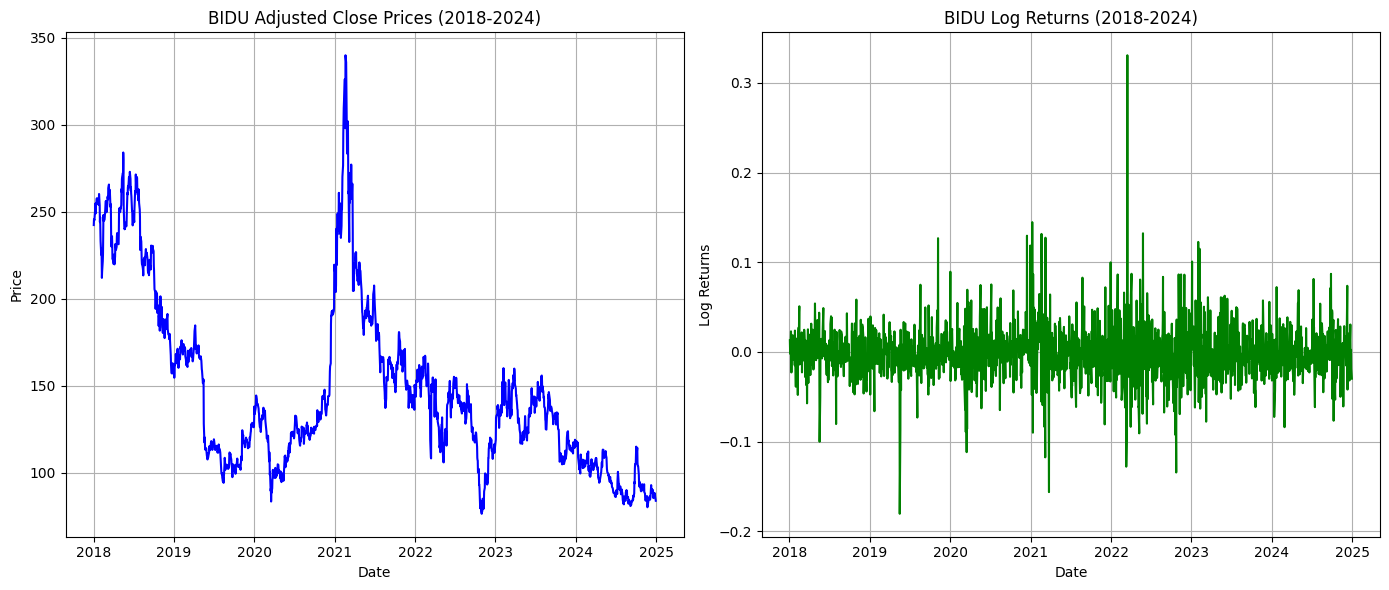

In [36]:
# Create a figure with two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Adjusted Close Prices
axs[0].plot(data_close.index, data_close, color='blue')
axs[0].set_title('BIDU Adjusted Close Prices (2018-2024)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].grid()

# Plot Log Returns
axs[1].plot(bidu_log_returns.index, bidu_log_returns, color='green')
axs[1].set_title('BIDU Log Returns (2018-2024)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Log Returns')
axs[1].grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

**Adjusted close price**
- High volatility
- Severe drawdown in 2022
- Exhibiting a decreasing trend

**Log returns**
- Stationary over most of the time
- Occasional spikes 
- Volatility Clustering

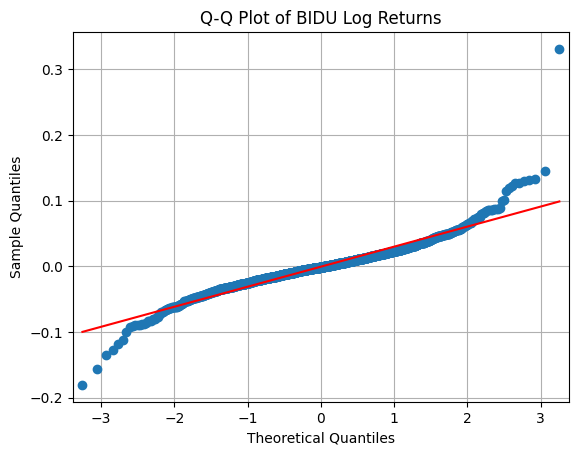

In [47]:
import statsmodels.api as sm

sm.qqplot(bidu_log_returns, line='s')
plt.title('Q-Q Plot of BIDU Log Returns')
plt.grid()
plt.savefig('qqplot.png', dpi=300)
plt.show()

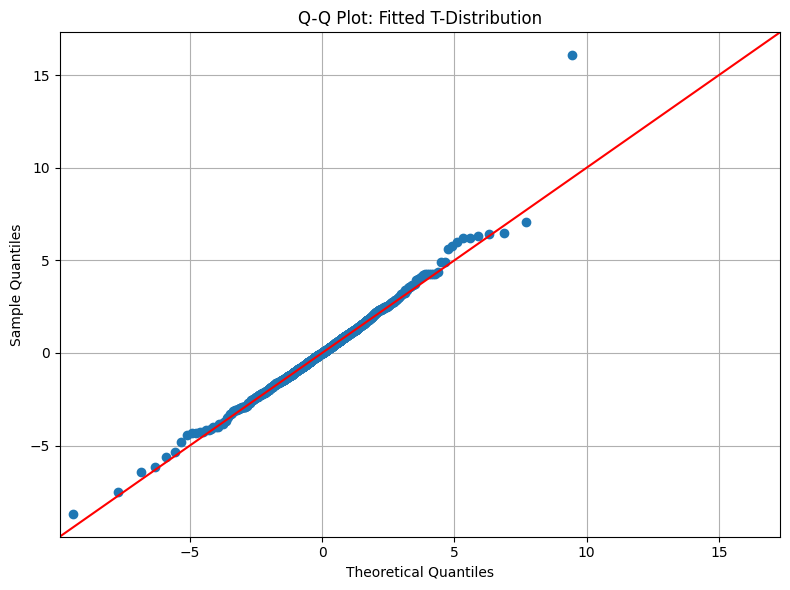

In [39]:
from scipy.stats import t

fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(bidu_log_returns, dist=t, fit=True, line='45', ax=ax)
ax.set_title('Q-Q Plot: Fitted T-Distribution')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('qqplot_fitted_t_distribution.png', dpi=300)
plt.show()

**Normal-distribution**
- Heavier tails on both the left and right sides 
- Does not strictly follow normal distribution

**T-distribution**
- A better fit on the right tail

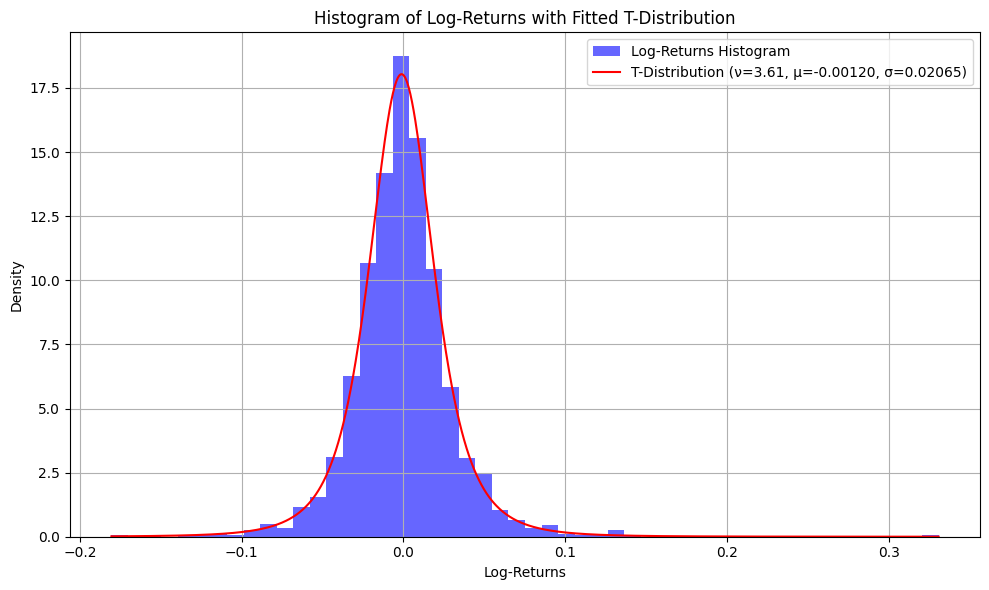

In [40]:
# Generate T-distribution PDF for overlay
x = np.linspace(bidu_log_returns.min(), bidu_log_returns.max(), 1000)
pdf_t = t.pdf(x, nu, loc=mu, scale=sigma)

# Plot histogram and T-distribution
plt.figure(figsize=(10, 6))
plt.hist(bidu_log_returns, bins=50, density=True, alpha=0.6, color='blue', label='Log-Returns Histogram')
plt.plot(x, pdf_t, 'r-', label=f'T-Distribution (ν={nu:.2f}, μ={mu:.5f}, σ={sigma:.5f})')
plt.title('Histogram of Log-Returns with Fitted T-Distribution')
plt.xlabel('Log-Returns')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot
plt.savefig('apple_t_fit.png')  # Save the figure to use in the slide
plt.show()

- The log-returns are approximately centered around zero, suggesting no significant upward or downward bias in the daily returns
- The distribution has heavier tails compared to a normal distribution
- T-distribution captures the shape and tail behavior of the returns well

### **2. Volatility Clustering: GARCH**

In [41]:
from arch import arch_model
from statsmodels.nonparametric.smoothers_lowess import lowess

arch_model_t = arch_model(bidu_log_returns * 100, mean='AR', lags=1, vol='ARCH', p=1, dist='t')
arch_result_t = arch_model_t.fit(disp='off')

# Print summary of the model
print(arch_result_t.summary())

                              AR - ARCH Model Results                               
Dep. Variable:            ('Close', 'BIDU')   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.001
Vol Model:                             ARCH   Log-Likelihood:               -4263.32
Distribution:      Standardized Student's t   AIC:                           8536.64
Method:                  Maximum Likelihood   BIC:                           8564.00
                                              No. Observations:                 1758
Date:                      Sun, Feb 23 2025   Df Residuals:                     1756
Time:                              19:16:10   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

- **Mean Model (AR)**: the coefficient for the lagged returns is 0.00599, but it is not statistically significant (P>|t| = 0.824). This suggests no strong evidence of autocorrelation in the returns

- **Volatility Model (GARCH)**: alpha[1] = 0.2525 indicates that lagged squared residuals explain about 25.25% of the current variance. This term is significant (P>|t| ≈ 0.00), supporting the presence of volatility clustering.

### **3. Financial Risk Metrics**

#### **3.1 VaR**

In [42]:
# Function to compute VaR
def compute_var(returns, var_levels):
    var_results = {"VaR Level": [], "Historical": [], "Normal": [], "T-dist": []}

    # Convert confidence levels to quantiles
    quantiles = [1 - alpha for alpha in var_levels]

    # Fit t-distribution to data
    df, loc, scale = stats.t.fit(returns)

    for alpha, quantile in zip(var_levels, quantiles):
        # Non-parametric (Historical Simulation)
        var_hist = np.percentile(returns, 100 * quantile)

        # Parametric Normal Distribution
        mean, std = returns.mean(), returns.std()
        var_norm = mean + std * stats.norm.ppf(quantile)

        # Parametric T-Distribution
        var_t = stats.t.ppf(quantile, df, loc=loc, scale=scale)

        # Store results
        var_results["VaR Level"].append(alpha)  # Fix: Append alpha instead of quantile
        var_results["Historical"].append(var_hist)
        var_results["Normal"].append(var_norm)
        var_results["T-dist"].append(var_t)

    return pd.DataFrame(var_results)

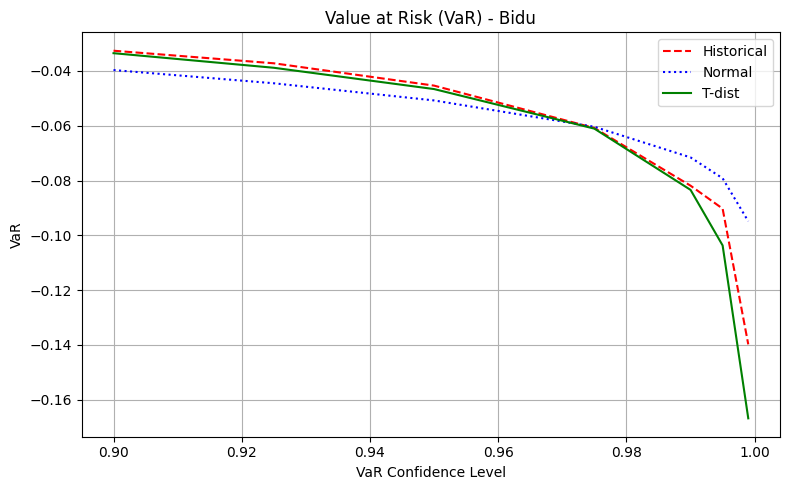

,VaR Level,Historical,Normal,T-dist
0,0.99,-0.081879,-0.071567,-0.083413


In [43]:
# User input: VaR confidence levels (e.g., 0.90, 0.925, 0.95, 0.975, 0.99, 0.995, 0.999)
var_levels = [0.90, 0.925, 0.95, 0.975, 0.99, 0.995, 0.999]

# Compute VaR for both assets
var_bidu = compute_var(bidu_log_returns, var_levels)

plt.figure(figsize=(8, 5))

# Bidu VaR
plt.plot(var_bidu["VaR Level"], var_bidu["Historical"], label="Historical", linestyle="dashed", color="r")
plt.plot(var_bidu["VaR Level"], var_bidu["Normal"], label="Normal", linestyle="dotted", color="b")
plt.plot(var_bidu["VaR Level"], var_bidu["T-dist"], label="T-dist", linestyle="solid", color="g")
plt.title("Value at Risk (VaR) - Bidu")
plt.xlabel("VaR Confidence Level")
plt.ylabel("VaR")
plt.legend()
plt.grid()



plt.tight_layout()
plt.show()

compute_var(bidu_log_returns, [0.99])

**At a 99% confidence level**:
- The T-distribution VaR is approximately -9%.
- This means that, under the T-distribution model, there is only a 1% chance that the portfolio will experience a loss exceeding 9% in one trading day.


#### **3.2 ES**

In [44]:
# Function to compute ES
def compute_es(returns, es_levels):
    es_results = {"ES Level": [], "Historical": [], "Normal": [], "T-dist": []}

    # Convert confidence levels to quantiles
    quantiles = [1 - alpha for alpha in es_levels]

    # Fit t-distribution to data
    df, loc, scale = stats.t.fit(returns)

    for alpha, quantile in zip(es_levels, quantiles):
        # Non-parametric (Historical Simulation)
        var_hist = np.percentile(returns, 100 * quantile)  # Compute VaR
        es_hist = returns[returns <= var_hist].mean()  # Compute mean of worst losses

        # Parametric Normal Distribution (Correct Left-Tail Formula)
        mean, std = returns.mean(), returns.std()
        phi_alpha = stats.norm.pdf(stats.norm.ppf(quantile))  # PDF of standard normal
        es_norm = mean - std * (phi_alpha / (1 - alpha))  # Adjusted for left tail

        # Parametric T-Distribution (Correct Left-Tail Formula)
        t_alpha = stats.t.ppf(quantile, df)
        t_pdf_alpha = stats.t.pdf(t_alpha, df)
        es_t = loc - scale * (t_pdf_alpha / (1 - alpha)) * (df + t_alpha**2) / (df - 1)

        # Store results
        es_results["ES Level"].append(alpha)
        es_results["Historical"].append(es_hist)
        es_results["Normal"].append(es_norm)
        es_results["T-dist"].append(es_t)

    return pd.DataFrame(es_results)

<Figure size 800x500 with 0 Axes>

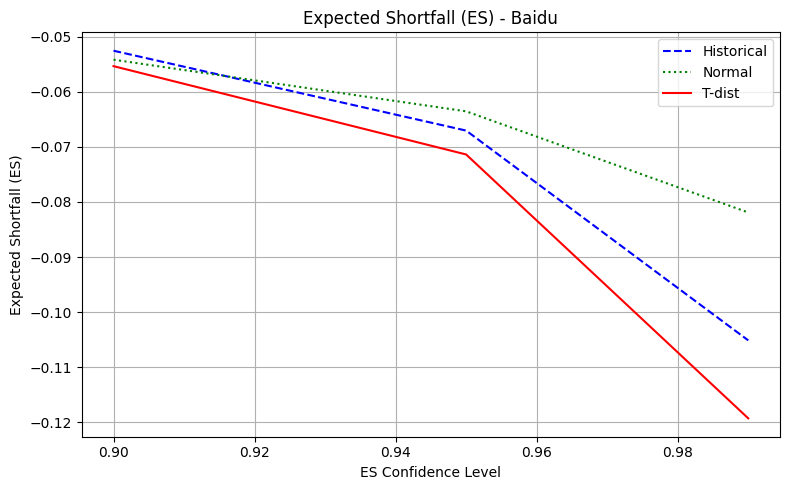

In [45]:
# Compute ES 
es_bidu = compute_es(bidu_log_returns, es_levels)

plt.figure(figsize=(8, 5))

# Plot ES results for Baidu
plt.figure(figsize=(8, 5))
plt.plot(es_bidu["ES Level"], es_bidu["Historical"], label="Historical", linestyle="dashed", color="b")
plt.plot(es_bidu["ES Level"], es_bidu["Normal"], label="Normal", linestyle="dotted", color="g")
plt.plot(es_bidu["ES Level"], es_bidu["T-dist"], label="T-dist", linestyle="solid", color="r")
plt.title("Expected Shortfall (ES) - Baidu")
plt.xlabel("ES Confidence Level")
plt.ylabel("Expected Shortfall (ES)")
plt.legend()
plt.grid()

# Save and show
plt.tight_layout()
plt.show()

ES values become more negative as the confidence level increases, indicating greater expected losses in extreme scenarios